In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
import os

import nba_api
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.static import players
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import commonallplayers as cap

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from mar_designs import tidy_axes

In [12]:
# Variables for the notebook
facecolor = "#F7F5F2"
figsize=(11,6)
subplotFigsize=(28,6)
titlesize=16
labelsize=14

pd.set_option('display.max_columns', None)

## Look at all endpoints in nba_api.stats

In [13]:
# help(nba_api.stats.endpoints)

## $\bf{All\space time\space leaders}$ endpoint

In [14]:
import nba_api.stats.endpoints.alltimeleadersgrids as atlg

In [16]:
# Request endpoint and get data into a large dictionary
allTimes = atlg.AllTimeLeadersGrids()
data = allTimes.get_dict()

In [17]:
# Print categories of leaders
allTimeDicts = data["resultSets"]
for i, d in enumerate(allTimeDicts):
    print(i, d["name"])

0 GPLeaders
1 PTSLeaders
2 ASTLeaders
3 STLLeaders
4 OREBLeaders
5 DREBLeaders
6 REBLeaders
7 BLKLeaders
8 FGMLeaders
9 FGALeaders
10 FG_PCTLeaders
11 TOVLeaders
12 FG3MLeaders
13 FG3ALeaders
14 FG3_PCTLeaders
15 PFLeaders
16 FTMLeaders
17 FTALeaders
18 FT_PCTLeaders


In [20]:
# Get IDs of top 10 leaders in points and assists
pointsLeadersIDs = [l[0] for l in allTimeDicts[1]["rowSet"]]
assistsLeadersIDs = [l[0] for l in allTimeDicts[2]["rowSet"]]

In [21]:
# Merge lists and remove duplicates to create a list of of leaderIDs
leaderIDs = list(set(assistsLeadersIDs + pointsLeadersIDs))

## Use $\bf{common\space all\space players}$ endpoint to get IDs of all active players

In [22]:
allPlayers = cap.CommonAllPlayers()
data = allPlayers.get_dict()

In [23]:
activePlayerIDs = []
allPlayers = data["resultSets"][0]
for i, playerRow in enumerate(allPlayers["rowSet"]):
    
    # Check that they're active
    if playerRow[5] == "2024":
        # print(i, playerRow)
        activePlayerIDs.append(playerRow[0])

In [26]:
# Remove leaderIDs from activePlayerIDs to distingush leaders from not
activePlayerIDs2 = list(set(activePlayerIDs) - set(leaderIDs))

## Now that I have two lists: `activePlayerIDs2` and  `leaderIDs`, I can see if there are groupings based on points versus assists using $\bf{player\space career\space stats}$ endpoint.

In [36]:
# Get minutes, points, assists of all in the leadersIDs list
minutesPointsAssistsLeaders = []
for i, ID in enumerate(leaderIDs):
    career = playercareerstats.PlayerCareerStats(player_id=ID) 
    careerDF = career.get_data_frames()[0]
    minPtsAsts = careerDF[["MIN", "PTS", "AST"]].sum().to_list()
    minPtsAsts.append("LEADER")
    minutesPointsAssistsLeaders.append(minPtsAsts)
    time.sleep(5) # prevents timing out

In [39]:
# Create a dataframe of the leaders data. This will be added later to non leaders for saving the cleaned data.
leadersDF = pd.DataFrame(minutesPointsAssistsLeaders, columns=["MIN", "PTS", "AST", "LEADER"])

In [ ]:
# This data was used to get career stats of every active player. 
# It takes a WHILE to run this (~1.5 hours). 
# To get around this, I stored each player's data in data/module2_data/playerCareerStats
# The following cell reads from that list to speed up the data recovery process.

# allPlayersSimple = players.get_players()
# for i, ID in enumerate(activePlayerIDs):
#     career = playercareerstats.PlayerCareerStats(player_id=ID) 
#     dfCareer = career.get_data_frames()[0]
    
#     # Get name of player with ID. If list is empty, pass and move on. 
#     listName = [row["full_name"] for row in allPlayersSimple if row["id"] == ID]
#     if listName:
#         name = listName[0].replace(" ", "_")
#         dfCareer.to_csv(f"../data/playerCareerStats/{name}.csv")
        
#     time.sleep(5)

In [59]:
minutesPointsAssists = []
path = "../data/module2_data/playerCareerStats/"
for playerSheet in os.listdir(path):
    
    if playerSheet !=  ".ipynb_checkpoints":
        
        dfCareer = pd.read_csv(os.path.join(path, playerSheet), usecols=['MIN', 'PTS', 'AST', "PLAYER_ID"])
        try:
            playerID = dfCareer["PLAYER_ID"].unique()[0]
        except:
            # Sometimes dataframes are empty. Print them, if so.
            print(playerSheet)
            print(dfCareer)
            print()
        
        if playerID not in leaderIDs:
            minPtsAsts = dfCareer[["MIN", "PTS", "AST"]].sum().to_list()
            minPtsAsts.append("NONLEADER")
            minutesPointsAssists.append(minPtsAsts)

DaRon_Holmes_II.csv
Empty DataFrame
Columns: [PLAYER_ID, MIN, AST, PTS]
Index: []

Isaiah_Stevens.csv
Empty DataFrame
Columns: [PLAYER_ID, MIN, AST, PTS]
Index: []

Nikola_Topić.csv
Empty DataFrame
Columns: [PLAYER_ID, MIN, AST, PTS]
Index: []

Tolu_Smith.csv
Empty DataFrame
Columns: [PLAYER_ID, MIN, AST, PTS]
Index: []



In [115]:
# Create a dataframe for non leaders data before merging with leadersDF
nonleadersDF = pd.DataFrame(minutesPointsAssists, columns=["MIN", "PTS", "AST", "LEADER"])
df_clean_kmeans = pd.concat([nonleadersDF, leadersDF])

df_clean_kmeans.to_csv("../data/module2_data/kmeans_clean_data.csv")
df_clean_kmeans.sample(frac=1).head(3)

,MIN,PTS,AST,LEADER
228,2498.0,862.0,168.0,NONLEADER
6,48654.0,33643.0,6306.0,LEADER
78,2133.0,666.0,303.0,NONLEADER


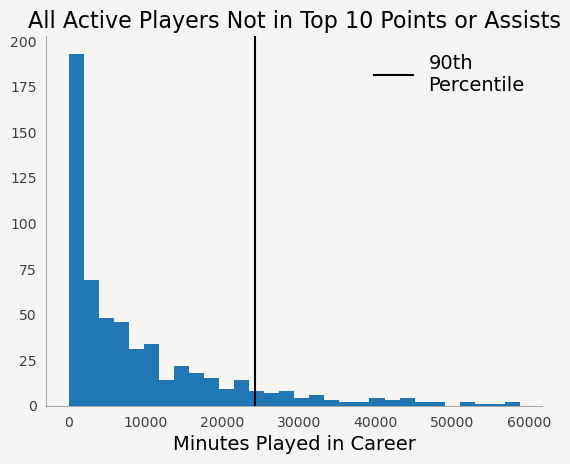

In [240]:
# Histogram all minutes played
minutes = df_clean_kmeans["MIN"]
threshold = np.percentile(minutes, 90)

fig, ax = plt.subplots()
ax.hist(minutes, bins=30)
ax.axvline(threshold, color="k", label="90th\nPercentile")
ax.legend(loc="best")
tidy_axes(ax)

ax.set_xlabel("Minutes Played in Career", fontsize=14)
ax.set_title("All Active Players Not in Top 10 Points or Assists", fontsize=titlesize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/minutes_played_all_players.png")

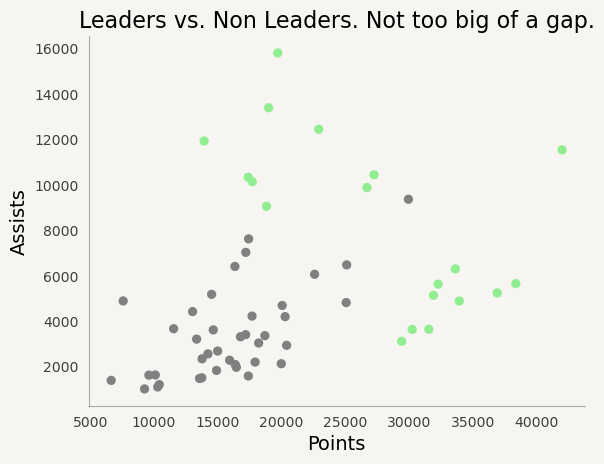

In [249]:
# Include in the plot only players above the 95th percentile in time played
numAboveThreshold = np.sum(df_clean_kmeans["MIN"]>threshold)
df_top_95 = df_clean_kmeans.sort_values(by="MIN", ascending=False).head(numAboveThreshold)
colors = df_top_95["LEADER"].map({"LEADER":"lightgreen", "NONLEADER":"grey"})

fig, ax = plt.subplots()
df_top_95.plot(kind='scatter', x='PTS', y='AST', c=colors, ax=ax, s=32)

tidy_axes(ax)
ax.set_xlabel("Points", fontsize=labelsize)
ax.set_ylabel("Assists", fontsize=labelsize)
ax.set_title("Leaders vs. Non Leaders. Not too big of a gap.", fontsize=titlesize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/pts_asts_scatter.png")
plt.show()

In [250]:
# Normalize it
scaler = StandardScaler()
normalized_top_95 = scaler.fit_transform(df_top_95.drop(columns=["LEADER", "MIN"]))

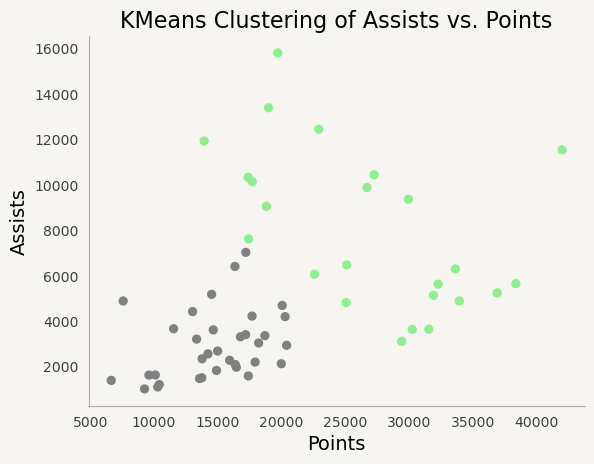

In [251]:
fig, ax = plt.subplots()

kmeans = KMeans(n_clusters=2)
kmeans.fit(normalized_top_95)

labels = pd.Series(kmeans.labels_).map({0:"lightgreen", 1:"grey"})
df_top_95.plot(kind='scatter', x='PTS', y='AST', c=labels, ax=ax, s=32)

tidy_axes(ax)
ax.set_title("KMeans Clustering of Assists vs. Points", fontsize=titlesize)
ax.set_xlabel("Points", fontsize=14)
ax.set_ylabel("Assists", fontsize=14)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
plt.savefig("../images/module2_images/kmeans.png")
plt.show()

In [252]:
# Calculate accuracy. Note that colors array is proxy for LEADER classification
colors.index = range(0, len(labels))
acc = (colors == labels).sum()/len(colors)
acc

0.9137931034482759

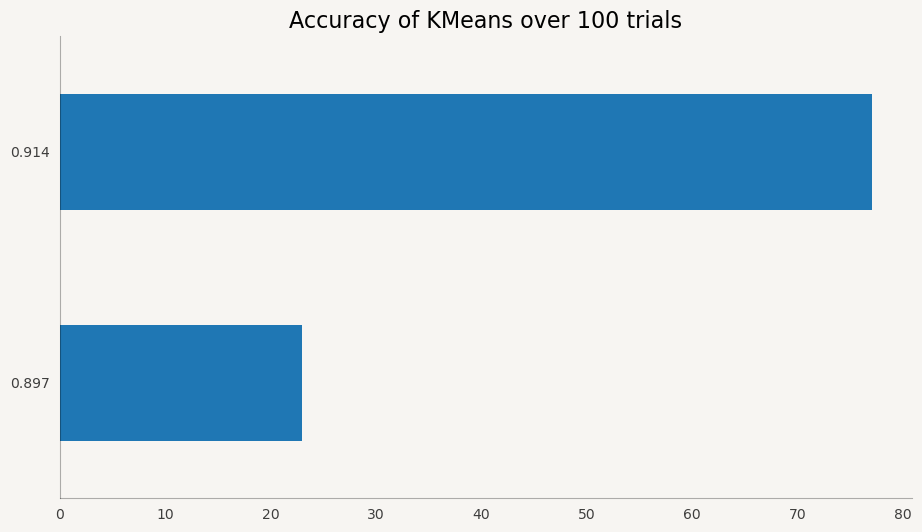

In [254]:
# Perform mini simulation to determine the accuracy distribution
accuracies = []
for _ in range(100):
    
    kmeans.fit(normalized_top_95)
    labels = pd.Series(kmeans.labels_).map({0:"lightgreen", 1:"grey"})
    acc = (colors == labels).sum()/len(colors)
    acc = float(f"{acc:.3f}")
    # Accounts for clusters switching
    if acc < 0.5:
        acc = 1 - acc
    
    accuracies.append(acc)


fig, ax = plt.subplots(figsize=figsize)
series = pd.Series(accuracies).value_counts(ascending=True)
series.plot(kind="barh", ax=ax)
ax.set_title("Accuracy of KMeans over 100 trials", fontsize=titlesize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)
tidy_axes(ax)
plt.savefig("../images/module2_images/kmeans_sim.png")
plt.show()

## Look at the leaguedashplayers endpoint for all player stats over the 2023-2024 year
### This data will be used for DBSCAN and Hierarchecal clustering

In [3]:
# Get player stats for the previous season
df = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]

# All quantitative variables
features = [
     'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
    'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV',
    'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']

X = df[features].dropna()

# Add a pseudolabel for starters
df['STARTER'] = df["MIN"]/df["GP"] >= 25

In [4]:
# Show head of data
df.to_csv("../data/module2_data/leaguedashplayerstats.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 67 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PLAYER_ID              572 non-null    int64  
 1   PLAYER_NAME            572 non-null    object 
 2   NICKNAME               572 non-null    object 
 3   TEAM_ID                572 non-null    int64  
 4   TEAM_ABBREVIATION      572 non-null    object 
 5   AGE                    572 non-null    float64
 6   GP                     572 non-null    int64  
 7   W                      572 non-null    int64  
 8   L                      572 non-null    int64  
 9   W_PCT                  572 non-null    float64
 10  MIN                    572 non-null    float64
 11  FGM                    572 non-null    int64  
 12  FGA                    572 non-null    int64  
 13  FG_PCT                 572 non-null    float64
 14  FG3M                   572 non-null    int64  
 15  FG3A  

In [5]:
# Snipping tool on this cell for image of cleaned data
X.to_csv("../data/module2_data/cleaned_data_DBSCAN.png")
X.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,54,121,0.446,13,50,0.260,15,23,0.652,14,36,50,20,14,10,3,8,22,13,136,18
1,83,196,0.423,69,169,0.408,17,19,0.895,9,55,64,30,12,9,4,3,49,20,252,50
2,18,62,0.290,10,39,0.256,2,2,1.000,2,16,18,5,8,1,2,3,6,1,48,-51
3,398,716,0.556,40,138,0.290,177,269,0.658,174,297,471,259,105,56,45,57,142,223,1013,423
4,186,417,0.446,84,217,0.387,58,63,0.921,23,100,123,140,53,42,6,20,125,65,514,85


## DBSCAN clustering via PCA

In [6]:
# PCA object on scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2 components
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

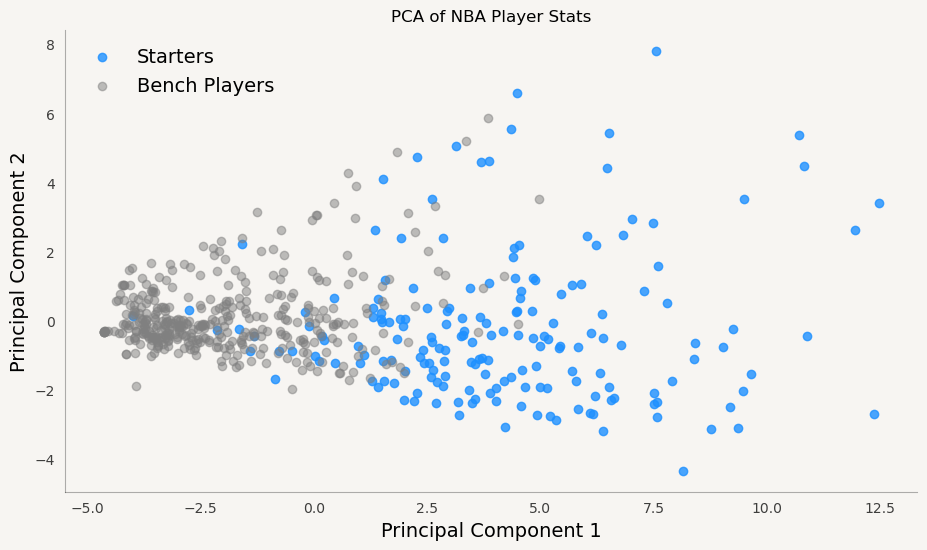

In [7]:
# Create a mask based on STARTER feature
starter_mask = df['STARTER'].values
nonstarter_mask = ~starter_mask

# Plot PCA with different colors
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

ax.scatter(X_pca_2[starter_mask, 0], X_pca_2[starter_mask, 1], alpha=0.8, label='Starters', color='dodgerblue')
ax.scatter(X_pca_2[nonstarter_mask, 0], X_pca_2[nonstarter_mask, 1], alpha=0.5, label='Bench Players', color='gray')

ax.set_title('PCA of NBA Player Stats')
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(loc=2, frameon=False, fontsize=labelsize)
plt.show()


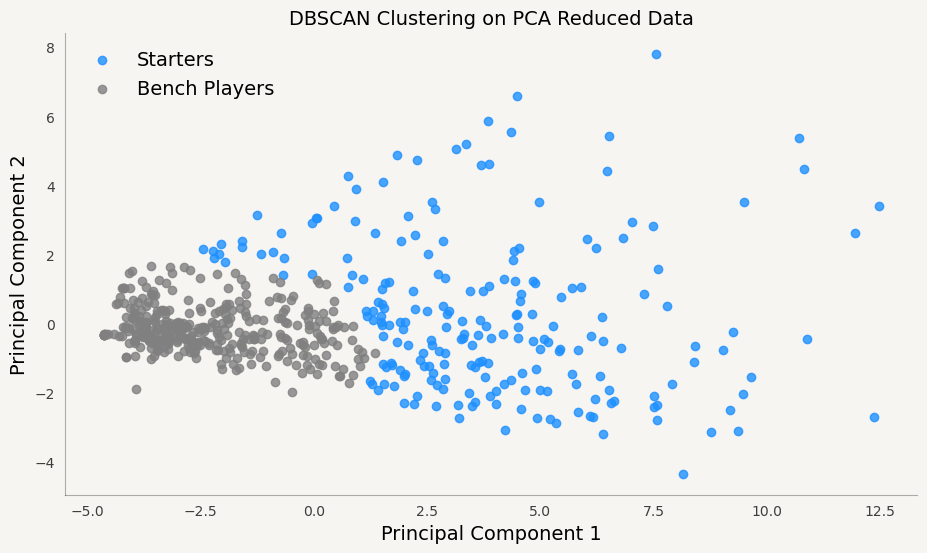

0.8706293706293706


In [8]:
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

# DBSCAN
clustering = DBSCAN(eps=1, min_samples=45).fit(X_pca_2)
labels = clustering.labels_

# Plot points by cluster
unique_labels = np.unique(labels)
for label in unique_labels:
    mask = labels == label
    ax.scatter(X_pca_2[mask, 0], X_pca_2[mask, 1],  alpha=0.8,
               label="Bench Players" if label != -1 else "Starters",
               c='dodgerblue' if label == -1 else "grey")

ax.set_title('DBSCAN Clustering on PCA Reduced Data', fontsize=labelsize)
ax.set_xlabel('Principal Component 1', fontsize=labelsize)
ax.set_ylabel('Principal Component 2', fontsize=labelsize)
tidy_axes(ax)
ax.legend(fontsize=labelsize, frameon=False, loc=2)
plt.savefig("../images/module2_images/dbscan.png")
plt.show()

# See how accurate clustering is
cluster_accuracy = (df['STARTER'] == -1*labels).sum()/len(df)
print(cluster_accuracy)

### Hierarchical Clustering

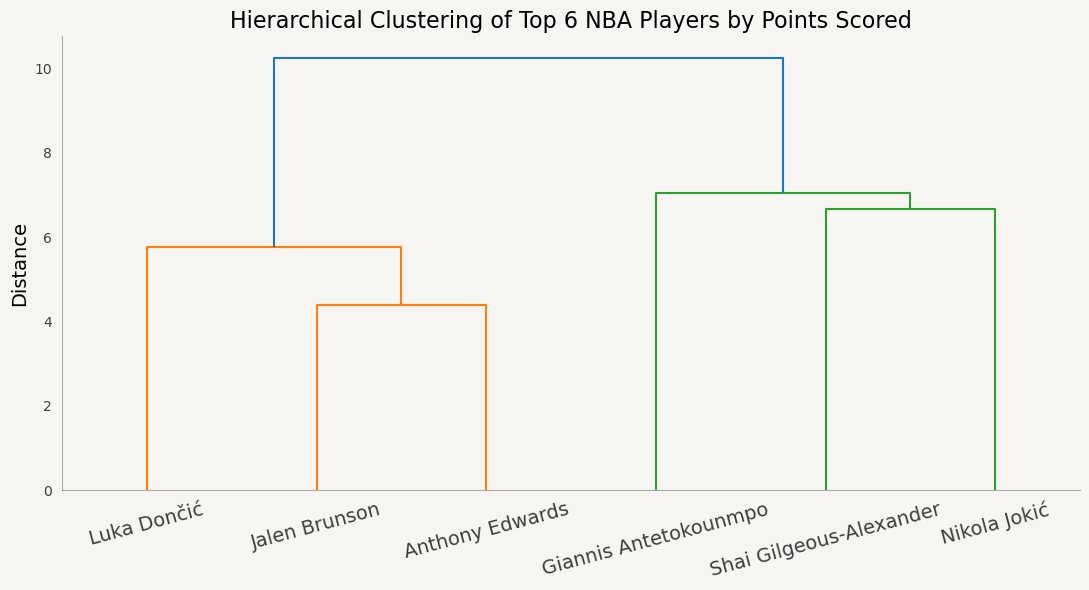

In [9]:
fig, ax = plt.subplots(figsize=figsize)
fig.set_facecolor(facecolor)
ax.set_facecolor(facecolor)

top_scorers_df = df.sort_values(by='PTS', ascending=False).head(6)

X_top_scorers = top_scorers_df[features].dropna()
X_top_scaled = scaler.fit_transform(X_top_scorers)

# Use scaled data
linked = linkage(X_top_scaled, method='ward')

# Plot dendrogram
dendrogram(linked, labels=top_scorers_df['PLAYER_NAME'].values, leaf_rotation=15, leaf_font_size=labelsize)
ax.set_title('Hierarchical Clustering of Top 6 NBA Players by Points Scored', fontsize=titlesize)
ax.set_ylabel('Distance', fontsize=labelsize)
plt.tight_layout()
tidy_axes(ax)
plt.savefig("../images/module2_images/hierarchical_clustering.png")
plt.show()


In [10]:
X_top_scorers["NAME"] = top_scorers_df['PLAYER_NAME'].values
X_top_scorers.to_csv("../data/module2_data/top_6_scorers.csv")
X_top_scorers

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NAME
372,804,1652,0.487,284,744,0.382,478,608,0.786,59,588,647,686,282,99,38,50,149,477,2370,319,Luka Dončić
501,796,1487,0.535,95,269,0.353,567,649,0.874,65,350,415,465,162,150,67,77,184,480,2254,613,Shai Gilgeous-Alexander
184,837,1369,0.611,34,124,0.274,514,782,0.657,196,645,841,476,250,87,79,90,210,604,2222,339,Giannis Antetokounmpo
233,790,1648,0.479,211,526,0.401,421,497,0.847,43,235,278,519,186,70,13,64,144,480,2212,512,Jalen Brunson
434,822,1411,0.583,83,231,0.359,358,438,0.817,223,753,976,708,237,108,68,68,194,426,2085,682,Nikola Jokić
29,718,1558,0.461,190,532,0.357,423,506,0.836,52,378,430,405,241,101,42,56,141,336,2049,432,Anthony Edwards
